# MeowLab

> cat可能是你最常用的命令行工具之一，但是可能很少有人会关注cat的性能问题。
> 
> 但实际上，cat可能比你想的更加高效。在这个lab中，我们会一起来探索cat如此高效的秘密。

## 什么是cat

对于大部分同学来说，这个问题有些太trivial了。但是以防万一，还是在这里介绍一下，cat是一个GNU coreutils中的一个程序，它的作用是连接(con**cat**enate)一系列文件，并将其输出到标准输出流(stdout)中。

> 如果你愿意去找，你会发现这个lab中所有的代码都可以在GNU coreutils中找到，或者你用某个大模型，它可能也能写得不错。
> 但是，除了写代码以外，这个lab中也会包含一些分析和讨论。因此即使你选择直接去抄GNU coreutils中的代码，也不要直接不加思考的复制粘贴。

## 环境要求

* 操作系统：Linux（任何包含GNU coreutils的发行版）
* 编译器：本lab允许使用C/C++或者Rust，选择你喜欢的任何编译器即可。
* Python3.x：本lab一些地方需要你画图，推荐你使用matplotlib。另外，我们使用一个简单的脚本来生成测试文件。

## 在开始之前

这个项目的所有代码需要你自己动手来写，我们只提供了一个用于生成测试文件的脚本。

为了展示比较明显的测试效果，我们会生成一个2GB的测试文件，请确保你的磁盘拥有足够的空间。你可以运行下面这个单元格来查看你的电脑是否有足够的空间。这里我们使用了`df`命令，这个命令的作用是查看某个文件系统所在的磁盘的使用量。

In [1]:
%%bash
df -h /

avail=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[0-9.]*')
unit=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[a-zA-Z]*')
if [[ "$unit" == "M" || "$unit" == "K" ]]; then
    echo "Disk space is low: $avail$unit"
elif [[ "$unit" == "T" ]]; then
    echo "Disk space is sufficient: $avail$unit"
elif [[ "$unit" == "G" ]]; then
    if (( $(echo "$avail < 10" | bc -l) )); then
        echo "Disk space is low: $avail$unit"
    else
        echo "Disk space is sufficient: $avail$unit"
    fi
else
    echo "Unknown unit: $unit"
fi


Filesystem      Size  Used Avail Use% Mounted on
/dev/sdd       1007G   36G  920G   4% /
Disk space is sufficient: 920G


你可以使用我们提供的python脚本来生成测试文件，运行下面的单元格。测试文件的生成可能会花费一定的时间。

In [2]:
import random

MB = 1024 * 1024

# A static seed for reproducibility
random.seed(42)

with open("test.txt", "wb") as f:
    for _ in range(2048):
        f.write(random.randbytes(1 * MB)) # 1MB of random data

当前文件夹下面会出现一个大小为2GB的文件`test.txt`。你可以运行下面的单元格来验证。

In [3]:
%%bash
ls -lh test.txt

-rw-r--r-- 1 dawn dawn 2.0G Jun 15 19:25 test.txt


最后，我们的lab会需要使用`hyperfine`来测量程序的运行时间。我们推荐你使用`cargo`进行安装。你可以从[Rust官网](https://www.rust-lang.org/zh-CN/learn/get-started)找到安装脚本。如果你的电脑已经安装好了`cargo`，你可以运行下面的单元格来安装`hyperfine`。

In [ ]:
%%bash
cargo install hyperfine

有了以上的准备工作，我们终于可以开始我们的探索之旅了。

## 任务0: 测量cat的效率

你要做的第一个任务十分简单。学习一下如何使用`hyperfine`，并且使用它来测试GNU coreutils中的cat输出我们生成的测试文件`test.txt`的时间。运行下面的单元格来运行测试。

In [1]:
%%bash
hyperfine --warmup 3 'cat test.txt'

Benchmark 1: cat test.txt
  Time (mean ± σ):     364.1 ms ±  25.4 ms    [User: 5.4 ms, System: 359.2 ms]
  Range (min … max):   328.2 ms … 398.9 ms    10 runs
 


## 任务1: 写一个最朴素的cat

我们现在使用`hyperfine`测量了GNU coreutils中的`cat`的运行效率，但是对于这个运行时间，我们可能并没有什么概念。现在我们将会写一个最朴素的`cat`程序来作为baseline。这个程序需要满足一下要求：
1. 把你的源代码命名为`mycat1.c`或者`mycat1.rs`，并且可执行的二进制文件命名为`mycat1`。
2. 你的程序接受且只接受一个命令行参数，这个参数是你要读取的文件。
3. 你的程序直接使用`read`和`write`系统调用，每次读取并输出一个字符，不使用任何缓冲区。
4. 使用`hpyerfine`测量`mycat1`和`cat`运行时间（`mycat1`的运行时间可能会非常长）
5. 虽然这是一个很简单的程序，但是请仍然保持系统编程的规范。请在你的代码中进行进行所有必要的错误处理。

这个任务不需要在文档中包含任何内容。

In [5]:
%%bash
hyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'

Benchmark 1: ./target/mycat1 test.txt
Process was interrupted.


CalledProcessError: Command 'b"hyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'\n"' died with <Signals.SIGINT: 2>.

## 任务2: 带有缓冲区的cat

如果你正确完成了上面的任务，你会发现，`mycat1`的性能和系统中的`cat`的性能相差甚远。但是经过了ics课程的学习，你肯定已经想到了至少一个解决方案——使用缓冲区。缓冲区可以有效减少反复进行系统调用的性能消耗。但是，我们要面临的第二个问题是：缓冲区的大小应该如何设置呢？我们接下来将一步一步地探索这个问题。

我们之前肯定也已经讲过不少涉及IO缓冲区的程序了，它们的缓冲区大小都被设置为多少呢？我相信1024, 4096, 8192一定是比较常见的几个数字。经过ics的学习，我相信你们肯定能说出原因了。那么，这个任务，我们将根据这个原理优化我们的`mycat1`。你至少需要完成下面要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat2.c`/`mycat2.rs`，可执行二进制文件命名为`mycat2`。
2. 写一个`io_blocksize`函数用于确定你的缓冲区的大小，在这个任务中，你可以将缓冲区设置成你当前系统中一个内存页的大小。（注意：你不能假设所有系统中内存页的大小都是4K，请你使用一个系统调用或者标准库中的函数来获取内存页的大小，而不要使用一个固定值。不过允许你使用一个固定值，如果获取内存页发生错误，但是这不应该是一个常见的情况）。
3. 使用标准库提供的函数动态分配用于缓冲区的内存。
4. 使用`hpyerfine`测量`mycat2`的运行时间
5. 请保持系统编程的基本规范。

这个任务不需要在文档中包含任何内容。

In [19]:
%%bash
hyperfine --warmup 3 './target/mycat2 test.txt'

Benchmark 1: ./target/mycat2 test.txt
  Time (mean ± σ):     775.1 ms ±  75.3 ms    [User: 103.4 ms, System: 671.8 ms]
  Range (min … max):   700.2 ms … 910.0 ms    10 runs
 


## 任务3: 缓冲区对齐的cat

如果你正确完成了上面这个任务，你会发现，添加了缓冲区的`mycat2`性能提升十分显著。但是我们还可以进一步优化。实际上只是添加了缓冲区并且设置缓冲区的大小为内存页的整数倍并不是没有什么太多的意义，这样的设置只是为了这个一个任务做铺垫的。在这个任务中，我们将尝试将我们的缓冲区对齐到系统的内存页。至于为什么要这么做，请大家在自己的文档中分析一下。你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat3.c`/`mycat3.rs`，可执行二进制文件命名为`mycat3`。
2. 写两个函数`char* align_alloc(size_t size)`和`void align_free(void* ptr)`，它们的作用分别是分配一段内存，长度不小于`size`并且返回一个对齐到内存页起始的指针`ptr`，以及给出一个先前从`align_alloc`返回的指针并释放之前分配的内存。
3. 利用这两个函数修改你的代码，缓冲区的大小仍然设置成一个内存页的大小。
4. 使用`hpyerfine`测量`mycat3`的运行时间
5. 请保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 为什么将缓冲区对齐到系统的内存可能提高性能？你的实验结果支持这个猜想吗？为什么？
2. 为什么我们直接使用`malloc`函数分配的内存不能对齐到内存页，即使我们分配的内存大小已经是内存页大小的整数倍了。
3. 你是怎么在不知道原始的malloc返回的指针的情况下正确释放内存的？

In [8]:
%%bash
hyperfine --warmup 3 './target/mycat3 test.txt'

Benchmark 1: ./target/mycat3 test.txt
  Time (mean ± σ):     707.2 ms ±  10.2 ms    [User: 99.2 ms, System: 608.0 ms]
  Range (min … max):   694.8 ms … 728.2 ms    10 runs
 


1. **为什么将缓冲区对齐到系统的内存可能提高性能？你的实验结果支持这个猜想吗？为什么？**

缓冲区对齐到系统的内存可以优化数据的传输效率

如果用户缓冲区没有对齐系统内存，跨越了多个页，拷贝次数和计算次数会变多，导致性能下降；而当用户缓冲区大小为一个页，并且起始地址也与页边界对齐时，这个缓冲区就完美地对应一个物理内存页；内核在拷贝数据时可能可以使用CPU的特殊指令或DMA引擎来执行一个“页到页”高速拷贝

实验结果是cat2为**775.1ms**，而cat3为**707.2ms**，这个提升不是很明显，因而不是很支持这个猜想

经查阅资料，这种优化在使用“直接I/O”时效果较好，而在使用“标准I/O”的情况下提升较小

我们现在使用的是“标准I/O”，这种情况下，调用`read()`，数据通常会先从磁盘被读入内核的页缓存中；然后，内核再将数据从页缓存拷贝到用户缓冲区里；因为内核数据拷贝的快速，对齐带来的提升较小，很容易被其他开销所掩盖

而对于“直接I/O”，它会绕过内核的页缓存，直接在磁盘和用户空间缓冲区之间传输数据；此时操作系统对用户缓冲区有严格的要求，其中一条就是缓冲区地址必须对齐到内存页边界，并且读写大小也必须是扇区大小的整数倍，如果满足这些条件，数据传输就可以通过DMA完成，无需CPU介入拷贝，数据传输路径更短，性能更高

综上，在内核的页缓存已经介入的情况下，对齐带来的收益较小，页缓存已经帮你优化了很多

2. **为什么我们直接使用`malloc`函数分配的内存不能对齐到内存页，即使我们分配的内存大小已经是内存页大小的整数倍了。**

malloc首要任务是在满足不同大小请求的同时，最大限度地减少内存碎片、提高内存利用率，并非专门为高性能I/O等特殊场景设计；同时，C语言标准只要求malloc返回的地址满足基本对齐，即可以存放任何基本数据类型而不会出错，这通常是8或16字节对齐

向malloc请求的内存大小只决定了它需要找到多大的一块连续内存，但这块内存的起始地址在哪里，完全取决于malloc内部的堆管理算法和当时堆的状态；它需要优先利用现有的、大小合适的空闲内存块，而不是为了对齐而去浪费内存

3. **你是怎么在不知道原始的malloc返回的指针的情况下正确释放内存的？**

在分配的指针前面多余的空间，可以把原始指针存起来；请求 `size + alignment - 1 + sizeof(void*)`这么多的内存，保证了我们有足够的空间来找到对齐地址并在对齐地址前多存一个指针。

当需要`free`时，只需在对齐地址前找回原指针，再对原指针进行`free`就行

## 任务4: 设置缓冲区大小为文件系统块大小的整数倍的cat

由于`cat`是涉及文件操作的，所以我们自然不能离开磁盘操作。我们在课内已经学到过，磁盘操作的基本单位是块。并且因为我们操作磁盘是经过了操作系统的一层抽象的，操作系统的文件系统也定义了一个操作文件的基本单位块，这个块的大小和磁盘的块的大小相关，但不总是相同。因此我们操作文件的时候实际接触到的块大小是文件系统的块大小。如果我们每次读取和写入文件的时候都按照文件系统的块大小来进行，也能提升性能。在这个任务中，你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat4.c`/`mycat4.rs`，可执行二进制文件命名为`mycat4`。
2. 修改你的函数`io_blocksize`，让你的缓冲区大小既考虑到内存页大小也考虑到文件系统的块大小。
3. 使用`hyperfine`测量`mycat4`的运行时间。
4. 保持系统编程的基本规范。

> 在完成这项任务的时候你需要注意以下几点：
> 1. 文件系统中的每个文件，块大小不总是相同的。
> 2. 有的文件系统可能会给出虚假的块大小，这种虚假的文件块大小可能根本不是2的整数次幂。

这个任务，你需要在文档中回答以下问题：
1. 为什么在设置缓冲区大小的时候需要考虑到文件系统块的大小的问题？
2. 对于上面提到的两个注意事项你是怎么解决的？

In [9]:
%%bash
hyperfine --warmup 3 './target/mycat4 test.txt'

Benchmark 1: ./target/mycat4 test.txt
  Time (mean ± σ):     707.4 ms ±   8.7 ms    [User: 101.3 ms, System: 606.3 ms]
  Range (min … max):   693.3 ms … 722.3 ms    10 runs
 


1. **为什么在设置缓冲区大小的时候需要考虑到文件系统块的大小的问题？**

文件在物理磁盘上以块为单位存储的；文件系统也使用“块”作为管理和读写的基本单元；当请求的数据量是文件系统块大小的整数倍时，请求可以直接映射到对一个或多个完整文件系统块的读取；这避免了内核为了满足请求去读取一个完整的块，但只拷贝其中一部分数据的情况，更充分地利用了磁盘

同时，如果要写入的数据不足一个文件系统块，并且不是从块的起始位置开始写，文件系统可能需要先将整个旧块读入内存，把新的数据合并进去，然后再把修改后的完整块写回磁盘；而通过使用块大小整数倍的缓冲区，可以确保大多数写操作都是以完整块的形式进行

2. **对于上面提到的两个注意事项你是怎么解决的？**

通过使用
```c
    struct stat file_stat;
    fstat(fd, &file_stat);
    long fs_block_size = file_stat.st_blksize;
```
可以得知所打开文件对应的块大小

在确定缓冲区大小时，如何既考虑到内存页大小也考虑到文件系统的块大小呢？答案是取二者之最小公倍数，使得缓冲区大小同时为内存页大小与文件系统块大小的倍数

因为内存页大小必为2的整数次幂，那么我们最后确定的缓冲区大小也必为2的整数次幂，如此，自然解决了第二个注意事项

## 任务5: 考虑系统调用开销情况下的cat

如果你正确完成了上面的任务，那么现在你的`cat`已经可以综合考虑内存页大小，内存页对齐和文件系统块大小的因素来设置缓冲区大小了。但是我们会发现，我们自己的`cat`性能仍然不如我们系统中的`cat`。并且如果你尝试过再进一步增大缓冲区的大小，你的`cat`性能还能更高。这是因为我们目前设置的缓冲区大小还不足以掩盖系统调用带来的开销。那么，我们的缓冲区究竟应该设置到什么大小才够呢？其实这个问题，我们仅仅使用理论分析是无法给出答案的，因为答案受到机器的硬件条件，操作系统的涉及等多重不确定因素的影响。但是，我们可以使用实验来解答这个问题。最后，我们还需要做出假设，不考虑上一个任务的注意事项1，也就是我们假设我们文件系统的大部分文件的块大小都一致（你可以使用我们的测试文件的块大小）。因此，设我们在之前的任务中设置的缓冲区大小是buf_size，我们需要通过实验找到一个倍数A，满足以下条件：
1. 当缓冲区大小小于A * buf_size的时候，文件的读写速度显著减小
2. 当缓冲区大小大于A * buf_size的时候，文件的读写速度并不显著提升
最终，我们就可以直接设置我们的`cat`中的缓冲区大小设置成buf_size的固定倍率。在这个任务中，你只少需要完成以下要求：
1. 编写一个实验脚本，尽量排除其他因素的影响，测量只在系统调用开销的影响下，你的系统最合适的缓冲区大小。并且给出这个大小下你的系统的读写速率。
2. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat5.c`/`mycat5.rs`，可执行二进制文件命名为`mycat5`。
3. 利用上面的实验结果，修改你的函数`io_blocksize`。
4. 使用`hyperfine`测量`mycat5`的运行时间。
5. 保持系统编程的基本规范。

> 提示：
> 1. `dd`命令可以用于复制一个文件(也就是读取并写入)，你可以使用命令行参数设置它的缓冲区大小，并且程序终止的时候可以报告平均文件读写速度。
> 2. Linux系统中存在`/dev`文件系统，这个目录下有很多特殊文件，其中有一些对你来说可能有用。`/dev/null`，你向这个文件写入的内容并不真正写入磁盘，并且不会对你的系统造成任何影响。`/dev/zero`，如果你尝试读取这个文件你会得到源源不断的`\0x0`，这个文件也并不真正的从磁盘中读取。

这个任务，你需要在文档中包括以下内容：
1. 解释一下你的实验脚本是怎么设计的。你应该尝试了多种倍率，请将它们的读写速率画成图表包含在文档中。

缓冲区大小 (KB)       | 吞吐率                 
---------------------|----------------------
4                    | 4.90 GB/s
8                    | 10.70 GB/s
16                   | 16.60 GB/s
32                   | 25.10 GB/s
64                   | 21.20 GB/s
128                  | 23.30 GB/s
256                  | 25.70 GB/s
512                  | 26.30 GB/s
1024                 | 20.30 GB/s
2048                 | 15.00 GB/s
4096                 | 14.30 GB/s
---------------------|----------------------


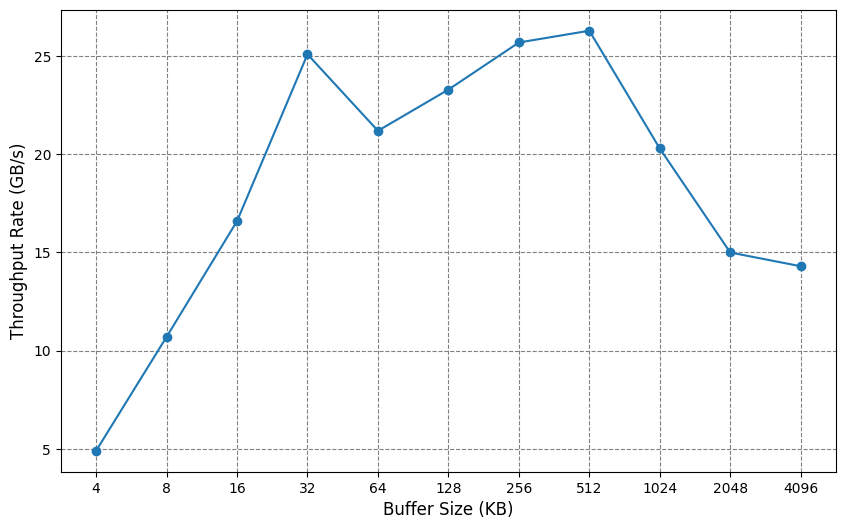

In [ ]:
# 请在这里填入你的测试脚本
import matplotlib.pyplot as plt
import re
import subprocess

def parse_dd_output(output_str): # 提取dd的报告数据
    match = re.search(r'(\d+\.?\d*)\s*([KMGT]?B/s)', output_str)
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        return value, unit
    return None, None

BASE_SIZE = 4096  # 原页大小为4kb，测试文件系统块大小也为4kb，则得原buffer_size为4096b
DATA_BYTES = 1 * 1024 * 1024 * 1024  # 用1GB来测试
MULTIPLIERS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] # 倍率A

# 结果存储
buffer_sizes = []
throughputs = []

print(f"{'缓冲区大小 (KB)':<16} | {'吞吐率':<20}")
print("-" * 21 + "|" + "-" * 22)

for A in MULTIPLIERS:
    block_size = A * BASE_SIZE
    count = DATA_BYTES // block_size
    
    command = [
        'dd',
        'if=/dev/zero',
        'of=/dev/null',
        f'bs={block_size}',
        f'count={count}'
    ]
    # 以bs为块，读写count次，bs起到缓冲区作用
    
    result = subprocess.run(
        command, 
        stderr=subprocess.PIPE, 
        stdout=subprocess.PIPE,
        text=True,
        check=True,
    )
    
    last_line = result.stderr.strip().splitlines()[-1]  # 有用的信息在stderr的最后一行
    value, unit = parse_dd_output(last_line)
    if value is not None:
        buffer_sizes.append(block_size // 1024)
        throughputs.append(value)
        print(f"{block_size // 1024:<20} | {value:.2f} {unit}")
    else:
        print(f"ERROR: {block_size} KB")

print("-" * 21 + "|" + "-" * 22)

plt.figure(figsize=(10, 6))
plt.plot(buffer_sizes, throughputs, marker='o', linestyle='-')

plt.xscale('log', base=2) # 使用对数刻度，因为是按2的幂次来测的

plt.xlabel('Buffer Size (KB)', fontsize=12)
plt.ylabel('Throughput Rate (GB/s)', fontsize=12)
plt.xticks(buffer_sizes, labels=[f"{size}" for size in buffer_sizes])

plt.grid(True, which="both", ls="--", c='0.5')

plt.show()

In [10]:
%%bash
hyperfine --warmup 3 './target/mycat5 test.txt'

Benchmark 1: ./target/mycat5 test.txt
  Time (mean ± σ):     350.9 ms ±  18.4 ms    [User: 1.3 ms, System: 350.1 ms]
  Range (min … max):   328.8 ms … 388.9 ms    10 runs
 


1. **解释一下你的实验脚本是怎么设计的。你应该尝试了多种倍率，请将它们的读写速率画成图表包含在文档中。**

脚本核心即为`dd`命令，利用`bs`参数控制读写块大小，即设置缓冲区大小

取输入文件为`/dev/zero`，对它的读取完全在内核内存中发生，不涉及任何物理磁盘的寻道和读取操作

同时，取输出文件为`/dev/null`，它会接收并丢弃所有写入它的数据，同样不涉及任何物理磁盘的写入操作

使用这两个输入输出使得我们可以将测量的瓶颈从磁盘读取转移到系统调用

为了研究缓冲区大小的影响，我们需要保证每次`dd`传输数据的总大小相同，这通过`bs`与`count`参数协调完成；`count`决定了要传输多少数量的块，而`bs`决定每次传输的块大小，只要使得`bs*count`为一常数即可，我这里取这个常数为1GB

综上，`dd`命令的主要工作就是从内核的一个缓冲区读取数据，通过一个用户空间的缓冲区进行中转，再写入到内核的另一个缓冲区，而这个过程的效率主要受限于`read()/write()`系统调用的开销，根据结果就可以知道最适合的缓冲区大小为多少了

实验后发现`test.txt`对应的文件系统块大小与这里的内存页大小均为4096，因而cat4的提升不大，因为cat4综合考虑二者后缓冲区大小仍为4096

据此可确定buf_size为4096，接下来对倍率A的取值进行测试，这里A取2的整数次幂[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

问题来了，我们总不可能一个个情况手动去试，所以这里我采用python的`subprocess`，利用它运行子进程，捕获并解析输出，自动化测试，最终根据输出作出图表

这里出现了两个极大点，经测试，取`512KB`效果略优于`32KB`，最终取`512KB`为缓冲区大小；此时系统对应吞吐量为`26.30 GB/s`

## 任务6: 使用了系统调用`fdadvice`的cat

虽然几乎我们的这个lab都在讨论设置缓冲区大小的问题，但是实际上我们的系统中的`cat`还在其他很多方面做了不少优化。这些优化在多数时候和缓冲区相比都不起决定性作用，但是我们也可以从中学习到不少有趣的技巧。这里我们就只尝试其中一个，使用系统调用`fadvise`。这个系统调用可以提示文件系统我们将会以什么样的模式来读写文件，这样操作系统可以设置合适的readahead窗口为文件的读写做准备。在这个任务中，你需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat6.c`/`mycat6.rs`，可执行二进制文件命名为`mycat6`。
2. 在你的代码中使用`fadvise`进行优化。
3. 使用`hyperfine`测量`mycat6`的运行时间。
4. 保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 你是如何设置`fadvise`的参数的？
2. 对于顺序读写的情况，文件系统可以如何调整readahead？对于随机读写的情况呢？

In [15]:
%%bash
hyperfine --warmup 3 './target/mycat6 test.txt'

Benchmark 1: ./target/mycat6 test.txt
  Time (mean ± σ):     362.0 ms ±  25.8 ms    [User: 1.3 ms, System: 361.0 ms]
  Range (min … max):   323.7 ms … 419.1 ms    10 runs
 


1. **你是如何设置`fadvise`的参数的？**

我按以下代码使用`fadvise`
```c
posix_fadvise(fd, 0, 0, POSIX_FADV_SEQUENTIAL);
```
其中第一个参数为文件描述符；

第二个参数为偏移量，它参数指定了建议生效的起始文件位置，而0表示从文件的最开始；

第三个参数为长度，当它为0时，表示这个建议从offset开始到文件末尾一直生效，而cat刚好就是要完整处理整个文件，所以设置为0

第四个参数是建议类型，我选择了`POSIX_FADV_SEQUENTIAL`，这表示接下来这个文件将被顺序读取，符合cat的工作流程

综上，我们告诉内核我们将从头到尾顺序读取整个文件，它就能更好地安排readahead

2. **对于顺序读写的情况，文件系统可以如何调整readahead？对于随机读写的情况呢？**

当顺序读写时，内核会增加预读的数据量；当应用程序正在读取文件的某一块时，内核可能已经开始将它后面的相邻块异步地从磁盘读入内存；最终，当应用程序调用`read`时，需要的数据很大概率已经存在于高速的内存页缓存中了

当随机读写时，情况与顺序读写时相反；此时进行预读效果不好，因为预读的数据在下一次`read`时被用到的概率很小；如果过多地预读会浪费I/O资源和缓存资源；因此，内核会大幅减少预读，按照实际需要进行读取，避免浪费

## 任务7: 总结

经过了上面的所有任务，我们已经成功探索我们系统中最常用的工具`cat`所使用的各种优化。我相信你对涉及系统IO的编程也有了更深刻的理解。现在请你整理汇总上面每个任务你所写的`mycatx`以及系统的`cat`的测量数据，使用一个柱状图来展示。并且请你分析一下你得到的结果：它们符合你的预期吗？为什么？这个结果给你带来了什么启示？

这个任务，你需要在文档中包含以下内容：
1. 你的全部实验结果的柱状图。
2. 你对上述实验结果的分析。

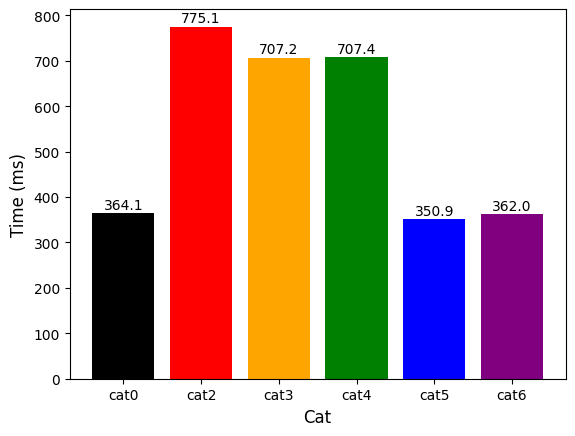

In [27]:
# 这里填入你用于画图的python代码
import matplotlib.pyplot as plt

values = [364.1, 775.1, 707.2, 707.4, 350.9, 362.0]
labels = ['cat0', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6']
colors = ['black', 'red', 'orange', 'green', 'blue', 'purple']

plt.bar(range(len(values)), values, color=colors)
plt.xticks(range(len(labels)), labels)

plt.xlabel('Cat', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)

for i, v in enumerate(values):
    plt.text(i, v+10, str(v), ha='center')

# plt.grid(True, which="both", ls="--", c='0.5')

plt.show()

1. **你的全部实验结果的柱状图。**

如图所示，因为cat1运行时间太久，这里忽略它

2. **你对上述实验结果的分析。**

结果并不是理想的每完成一步就大大提升一步，这给我带来了诸多启示

**cat1->cat2**: 巨大的提升，符合预期

原因：cat1进行了海量的系统调用，每次`read(1)`都是一次用户态到内核态的上下文切换;而通过在cat2引入缓冲区，我们大大减少了系统调用次数，提高了性能

启示：缓冲思想十分重要，了解每个函数和系统的运行原理是优化性能的不二法门

**cat2->cat3**：微小的提升，不符合一开始的预期

原因：“标准I/O”下，调用`read()`，数据通常会先从磁盘被读入内核的页缓存中；然后，内核再将数据从页缓存拷贝到用户缓冲区里；因为内核数据拷贝的快速，对齐带来的提升较小，很容易被其他开销所掩盖

启示：并非每一个优化都会有肉眼可见的成效，确定真正的瓶颈问题至关重要

**cat3->cat4**：几乎没有变化，不符合一开始的预期

原因：在cat5的探索中发现`test.txt`对应的文件系统块大小与内存页大小一致，那么最小公倍数策略等于没有起到作用，因而也就没什么性能变化

启示：理论的优化会有差池，要用实践来检验真理

**cat4->cat5**：显著的优化，符合预期

原因：通过增大缓冲区，增大单次I/O数据量，可以摊薄系统调用的开销

启示：利用`dd`和`/dev/null`、`/dev/zero`进行实验测试真是一个精巧的想法，设计实验是进行优化的重要组成部分；当我们发现瓶颈时，要利用各种方法和思维优化它

**cat5->cat6**：并没什么优化，反而有所降低，不符合预期

原因：这可能是由于现代的Linux内核已经非常智能，拥有自适应的预读算法；当程序开始顺序读取文件的前几个块时，内核会自动检测到这个顺序读取模式，并开始自动地执行预读操作；此时再用`fadvise`实际上是在告诉内核一件它已经知道并且已经在做的事情，这个“建议”是多余的，而且本身还有开销

启示：任何优化需要结合具体实际才能体现它的效果，要为优化找到适合它的“用武之地”，不存在所谓“万金油”

结合以上所有，还可以总结出以下**启示**：

1. **精益求精，永无止境**：一部分早期的优化可以带来巨大的提升(cat1->cat2)，而后续的工作则是在精益求精，我们要发扬这种精益求精的精神，也要锻炼识别并优先解决最主要的瓶颈的能力

2. **实践出真知**：理论分析为我们指明了优化的方向，但无法将所有细节都考虑周全，也往往难以给出一个适合所有情况的最佳方案；因此，我们要通过严谨的实验，在实践中验证理论、补充理论

3. **理解系统，与系统成为朋友**：程序是建立在系统之上的，不理解系统就不可能写出好的程序；深刻把握系统工作原理，并让我们的程序去配合它，才能取得最好的效果
